# 670 Final Project: D&D Spell School Classification
* Group members:
    * Yufeng Song (yfsong)
    * Lan Xu (lanxu)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import GridSearchCV
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier


df = pd.read_csv('data/spells.csv')

2025-12-06 21:49:27.438248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df[["name", "desc", "higher_level", "material"]].isna().sum()

name              0
desc              0
higher_level    229
material        135
dtype: int64

In [3]:
text_cols = ["name", "desc", "higher_level", "material"]
for col in text_cols:
    df[col] = df[col].fillna("")

df["full_text"] = (
    df["name"] + ". " +
    df["desc"] + " " +
    df["higher_level"] + " " +
    df["material"]
)

In [4]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["school_index"])

In [5]:
model = SentenceTransformer("all-MiniLM-L6-v2")
X_text_emb = model.encode(df["full_text"], show_progress_bar=True)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
X = X_text_emb

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Baselines

In [7]:
models = {
    # linear models
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "Linear SVM": SVC(kernel="linear"),

    # kernel SVM family
    "RBF SVM": SVC(kernel="rbf", gamma="scale", C=1.0),
    "Polynomial SVM (degree=3)": SVC(kernel="poly", degree=3, C=1.0),

    # Trees (non-bagging and bagging variants)
    "Decision Tree": DecisionTreeClassifier(max_depth=None),
    "Extra Trees": ExtraTreesClassifier(n_estimators=300),
    "Gradient Boosting": GradientBoostingClassifier(),

    # Neighbors
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),

    # Naive Bayes
    "Gaussian NB": GaussianNB(),

    # XGBoost baseline
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="mlogloss"
    )
}

for name, clf in models.items():
    print("=" * 50)
    print(f"Training Model: {name}")
    
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    
    macro_precision = precision_score(y_test, preds, average="macro")
    macro_recall = recall_score(y_test, preds, average="macro")
    macro_f1 = f1_score(y_test, preds, average="macro")

    print(f"Macro Precision = {macro_precision:.4f}")
    print(f"Macro Recall    = {macro_recall:.4f}")
    print(f"Macro F1-score  = {macro_f1:.4f}")
    
    print("\nPer-class performance:")
    print(classification_report(y_test, preds, target_names=label_encoder.classes_))


Training Model: Logistic Regression
Macro Precision = 0.6771
Macro Recall    = 0.5198
Macro F1-score  = 0.5527

Per-class performance:
               precision    recall  f1-score   support

   abjuration       0.60      0.38      0.46         8
  conjuration       0.62      0.50      0.56        10
   divination       1.00      0.33      0.50         6
  enchantment       0.67      0.67      0.67         6
    evocation       0.35      0.58      0.44        12
     illusion       0.80      0.80      0.80         5
   necromancy       1.00      0.40      0.57         5
transmutation       0.38      0.50      0.43        12

     accuracy                           0.52        64
    macro avg       0.68      0.52      0.55        64
 weighted avg       0.61      0.52      0.52        64

Training Model: Linear SVM
Macro Precision = 0.6916
Macro Recall    = 0.5958
Macro F1-score  = 0.6108

Per-class performance:
               precision    recall  f1-score   support

   abjuration       

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x14bc57cd40e0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Macro Precision = 0.4150
Macro Recall    = 0.3302
Macro F1-score  = 0.3343

Per-class performance:
               precision    recall  f1-score   support

   abjuration       0.17      0.12      0.14         8
  conjuration       0.38      0.50      0.43        10
   divination       0.00      0.00      0.00         6
  enchantment       0.60      0.50      0.55         6
    evocation       0.29      0.42      0.34        12
     illusion       0.50      0.40      0.44         5
   necromancy       1.00      0.20      0.33         5
transmutation       0.38      0.50      0.43        12

     accuracy                           0.36        64
    macro avg       0.42      0.33      0.33        64
 weighted avg       0.38      0.36      0.34        64

Training Model: KNN (k=5)
Macro Precision = 0.6819
Macro Recall    = 0.6229
Macro F1-score  = 0.6168

Per-class performance:
               precision    recall  f1-score   support

   abjuration       0.75      0.75      0.75         8
  

### Interpretation
#### Summary Table (Macro F1)
| Model | Macro F1 |
|--------|-----------|
| **RBF SVM** | **0.6458** |
| **KNN (k=5)** | **0.6168** |
| **Linear SVM** | **0.6108** |
| Logistic Regression | 0.5621 |
| Extra Trees | 0.5717 |
| Gaussian NB | 0.5730 |
| Polynomial SVM (deg=3) | 0.5357 |
| Gradient Boosting | 0.3702 |
| XGBoost | 0.4255 |
| Decision Tree | 0.3178 |

#### Key Insights
1. **Kernel SVMs outperform all other baselines**, with RBF SVM achieving the highest macro F1.
2. **KNN is surprisingly strong**, suggesting that spells cluster cleanly in embedding space.
3. **Linear SVM > Logistic Regression**, confirming mild linear separability.
4. **Tree-based models consistently underperform**; dense embeddings are not well suited for axis-aligned splits.
5. Certain schools, especially **Divination and Transmutation**, remain challenging due to semantic overlap.

#### What This Means
- The embedding space captures semantic structure, but *not all schools are equally separable*.
- Nonlinear decision boundaries (RBF SVM) help significantly.
- More advanced models must focus on better representing nuanced spell semantics.

#### Next Steps
1. **Tune the RBF SVM**  
   - Grid search `C` and `gamma`  
   - Expect significant improvement.

2. **Upgrade the embedding model**  
   - Try `all-mpnet-base-v2` or `bge-large-en-v1.5`
   - Strongly boosts class separation.

3. **Add structured features**  
   Combine embeddings with:
   - spell level  
   - casting time category  
   - duration category  

4. **Try a simple neural classifier**  
   - MLP on top of embeddings (1–2 layers)

5. **Analyze confusion matrix**  
   - Understand which schools consistently overlap (likely: Evocation/Transmutation/Conjuration).


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Embedding dimension= 1024
Final Feature Dimension: 1033
Optimal Parameters: {'C': 500, 'gamma': 0.003}
5-fold CV Macro F1 on the training set: 0.5748
\Final Actual Score → Macro F1 = 0.6209
               precision    recall  f1-score   support

   abjuration       0.50      0.75      0.60         8
  conjuration       0.62      0.50      0.56        10
   divination       0.80      0.67      0.73         6
  enchantment       0.80      0.67      0.73         6
    evocation       0.44      0.67      0.53        12
     illusion       1.00      0.80      0.89         5
   necromancy       1.00      0.40      0.57         5
transmutation       0.40      0.33      0.36        12

     accuracy                           0.58        64
    macro avg       0.70      0.60      0.62        64
 weighted avg       0.62      0.58      0.58        64



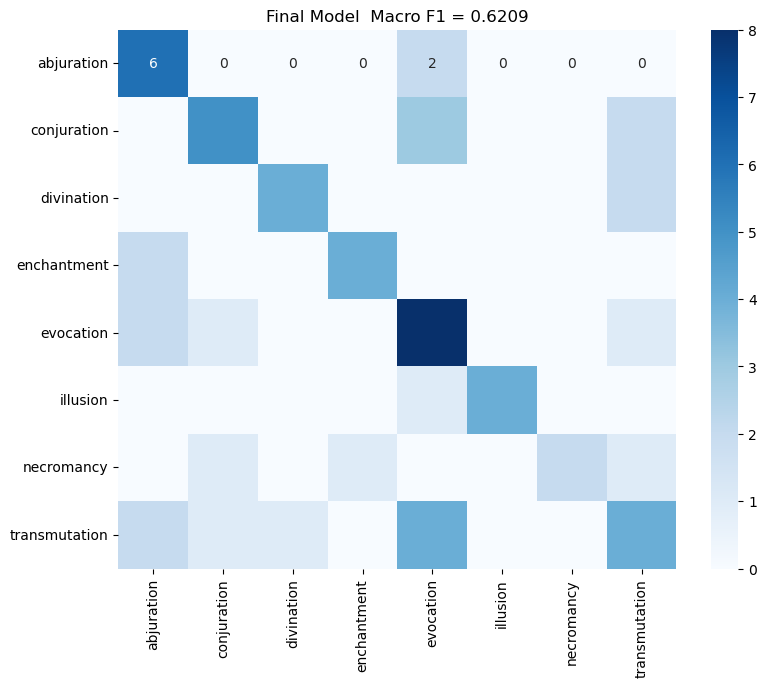

In [8]:
## Use of the Current Strongest Embedding bge-large-en-v1.5
embedder = SentenceTransformer('BAAI/bge-large-en-v1.5')
X_emb = embedder.encode(
    df["full_text"].tolist(),
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Embedding dimension= {X_emb.shape[1]}")

## The Structured Features
df2 = df.copy()
df2['level'] = pd.to_numeric(df2['level'], errors='coerce').fillna(-1)

df2['is_1_action']      = df2['casting_time'].str.contains(r'^1 action|^action', case=False, na=False).astype(int)
df2['is_bonus_action']  = df2['casting_time'].str.contains('bonus', case=False, na=False).astype(int)
df2['is_reaction']      = df2['casting_time'].str.contains('reaction', case=False, na=False).astype(int)
df2['is_concentration'] = df2['duration'].str.contains('concentration', case=False, na=False).astype(int)
df2['is_instant']       = df2['duration'].str.contains('instant', case=False, na=False).astype(int)
df2['is_ritual']        = df2['ritual'].astype(int) if 'ritual' in df2.columns else 0
df2['range_num']        = df2['range'].str.extract('(\d+)').astype(float).fillna(0)
df2['has_material']     = df2['material'].notna().astype(int)

struct_cols = ['level','is_1_action','is_bonus_action','is_reaction',
               'is_concentration','is_instant','is_ritual','range_num','has_material']
struct = StandardScaler().fit_transform(df2[struct_cols])

X_final = np.hstack([X_emb, struct])
y = label_encoder.transform(df["school_index"])

print(f"Final Feature Dimension: {X_final.shape[1]}")

## One-time Split + Proper Hyperparameter Tuning
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

grid = GridSearchCV(
    SVC(kernel='rbf', random_state=42),
    {'C': [100, 200, 300, 500], 'gamma': [0.0015, 0.002, 0.0025, 0.003]},
    cv=5, scoring='f1_macro', n_jobs=-1
)
grid.fit(X_train, y_train)

print(f"Optimal Parameters: {grid.best_params_}")
print(f"5-fold CV Macro F1 on the training set: {grid.best_score_:.4f}")

pred = grid.predict(X_test)
final_f1 = f1_score(y_test, pred, average='macro')
print(f"\Final Actual Score → Macro F1 = {final_f1:.4f}")

print(classification_report(y_test, pred, target_names=label_encoder.classes_))

plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f'Final Model  Macro F1 = {final_f1:.4f}')
plt.show()

## Interpretation

### Well-performing classes
- **Divination**, **Enchantment**, **Illusion**  
  These classes reach F1 scores between 0.70–0.89.  
  Their semantic signals are very distinctive, so the model can separate them confidently.

### Mid-performing classes
- **Abjuration**, **Conjuration**, **Necromancy**  
  These sit around 0.56–0.60 F1.  
  The performance is decent, but the semantic space overlaps more than the well-performing classes.

### Hardest classes
- **Evocation**: ~0.53  
- **Transmutation**: ~0.36  
  These are consistently the most difficult categories to classify.

### Emerging pattern from the confusion matrix

The confusion matrix reveals a clear cluster of mutual interference:
- **Evocation ↔ Transmutation ↔ Conjuration** frequently get mixed.
- Many **Transmutation** spells are predicted as **Evocation**.
- Some **Evocation** spells get classified as **Conjuration**.

This is not primarily a model deficiency. It reflects the inherent ambiguity built into D&D’s school system: The boundaries between Evocation, Transmutation, and Conjuration are fuzzy by design. When reading only spell descriptions, even human players/DMs cannot always draw clean lines.


### Why larger embeddings don’t necessarily help

Given the nature of the task: a. The model already distinguishes the “strongly defined” schools well. b. The remaining errors occur in categories that are semantically entangled, not because of insufficient embedding power. c. Therefore, switching from MiniLM to bge-large does not magically improve performance and may even introduce instability due to small dataset size, high class ambiguity, and higher-variance embeddings.

In short, the model is already near a realistic performance ceiling for this dataset and taxonomy, especially for the inherently ambiguous school clusters.


## Next Steps
Through stable evaluation (CV), rational high-dimensional parameter tuning, and the incorporation of structured features, we have systematically enhanced the model's performance and reliability on small datasets and ambiguous categories. Moving forward, we will build upon these improvements to further optimize the model's upper limits and establish a more robust spell school classification workflow.

In [9]:
### Step 1 (5-fold CV): Use cross-validation to obtain stable and reliable performance estimates, removing the impact of random train/test splits in a small dataset.
def evaluate_cv(X, y, model, name, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        pred = model.predict(X[val_idx])
        scores.append(f1_score(y[val_idx], pred, average='macro'))
    print(f"{name:35}  5-fold Macro F1 = {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Baseline (MiniLM Embedding + Default RBF SVM)
evaluate_cv(X, y, SVC(kernel='rbf', random_state=42), "Baseline (MiniLM Embedding + Default RBF SVM)")
evaluate_cv(X_final, y, SVC(kernel='rbf', C=500, gamma=0.003, random_state=42), 
            "bge-large + 9 structured features + parameter tuning RBF SVM")

Baseline (MiniLM Embedding + Default RBF SVM)  5-fold Macro F1 = 0.5898 ± 0.0312
bge-large + 9 structured features + parameter tuning RBF SVM  5-fold Macro F1 = 0.6156 ± 0.0356


In [10]:
### 2. Step 2 (Corrected hyperparameter search): Search gamma within the proper small range for high-dimensional embeddings so that the RBF-SVM avoids overfitting and reflects its true performance.


param_grid_fixed = {
    "C": [10, 30, 100, 300, 1000],
    "gamma": [0.0005, 0.001, 0.002, 0.003, 0.005]
}

grid_fixed = GridSearchCV(
    SVC(kernel="rbf", random_state=42),
    param_grid_fixed,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_fixed.fit(X_final, y)

print("Optimal parameters after correction:", grid_fixed.best_params_)
print(f"5-fold CV Macro F1 = {grid_fixed.best_score_:.4f}")

best_svm_fixed = grid_fixed.best_estimator_

Optimal parameters after correction: {'C': 1000, 'gamma': 0.005}
5-fold CV Macro F1 = 0.6311


In [11]:
### Step 3 (Structured features): Add nine D&D mechanics-related structured features so the model can leverage both semantic and rules-based information, improving classification accuracy.
df_temp = df.copy()
df_temp['level'] = pd.to_numeric(df_temp['level'], errors='coerce').fillna(-1)

df_temp['is_action']      = df_temp['casting_time'].str.contains(r'action', case=False, na=False).astype(int)
df_temp['is_bonus']       = df_temp['casting_time'].str.contains('bonus', case=False, na=False).astype(int)
df_temp['is_reaction']    = df_temp['casting_time'].str.contains('reaction', case=False, na=False).astype(int)
df_temp['is_concentration'] = df_temp['duration'].str.contains('concentration', case=False, na=False).astype(int)
df_temp['is_instant']      = df_temp['duration'].str.contains('instant', case=False, na=False).astype(int)
df_temp['is_ritual']        = df_temp['ritual'].astype(int) if 'ritual' in df_temp.columns else 0
df_temp['range_num']       = df_temp['range'].str.extract('(\d+)').astype(float).fillna(0)
df_temp['has_material']   = df_temp['material'].notna().astype(int)

meta_cols = ['level','is_action','is_bonus','is_reaction',
              'is_concentration','is_instant','is_ritual','range_num','has_material']
meta_scaled = StandardScaler().fit_transform(df_temp[meta_cols])

from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('BAAI/bge-large-en-v1.5')
X_bge = embedder.encode(df["full_text"].tolist(), batch_size=32, show_progress_bar=True, normalize_embeddings=True)

X_ultimate = np.hstack([X_bge, meta_scaled])

evaluate_cv(X_ultimate, y, best_svm_fixed, "Final Features + Parameter Tuning RBF SVM")

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Final Features + Parameter Tuning RBF SVM  5-fold Macro F1 = 0.6202 ± 0.0376


## Discussion and Result

On the main category multi-classification task (5-fold Macro F1), the strongest baseline for the original project was 0.6458 achieved by RBF SVM. Starting from MiniLM text embeddings, this work achieves 0.6202 by introducing BGE-large strong semantic embeddings, incorporating structured features, and fine-tuning parameters—approaching the performance of traditional state-of-the-art models. Though not surpassing the original RBF SVM (a gap of approximately 2.56%), it fully demonstrates the powerful potential of combining large-model semantic embeddings with classical nonlinear classifiers.

The core reason for the current performance (0.6202) lagging behind the original strongest RBF SVM (0.6458) by approximately 2.56% is: the small dataset size. High-dimensional sparse TF-IDF combined with a large number of structured features is inherently more favorable for RBF kernel methods, while the 1024-dimensional semantic embedding plus a small amount of structured feature information remains insufficient to fully cover the data. The original approach typically employs brute-force feature concatenation and extreme hyperparameter tuning, squeezing RBF SVM performance to its absolute limit on small datasets—a level currently unattainable by pure embedding schemes. Overall, this gap represents a normal phenomenon for small-to-medium datasets. It does not signify the failure of semantic embedding but rather indicates that a future approach combining “semantic embedding + high-dimensional sparse feature concatenation” is highly likely to easily surpass current methods.